In [ ]:
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.models import Sequential
import time #helper libraries

In this notebook I normalized only the closing prices and then broke it into train and test datasets. I just kept a simple lookback window to give all similar data same movement(movement is just giving the data points the same kind of normalization) and put them in price points as input

In [ ]:
import pandas as pd
df3 = pd.read_csv("AMZN.csv")
df3

,Date,Open,High,Low,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,Fourier,ARIMA,Close,labels
0,1/4/2010,136.250000,136.610001,133.139999,133.899994,7599900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.899994,NaN
1,1/5/2010,133.429993,135.479996,131.809998,134.690002,8851900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,134.690002,NaN
2,1/6/2010,134.600006,134.729996,131.649994,132.250000,7178800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,132.250000,NaN
3,1/7/2010,132.009995,132.320007,128.800003,130.000000,11030200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.000000,NaN
4,1/8/2010,130.559998,133.679993,129.029999,133.520004,9830500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,133.520004,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260,12/26/2018,1368.890015,1473.160034,1363.010010,1470.900024,10411800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1470.900024,NaN
2261,12/27/2018,1454.199951,1469.000000,1390.310059,1461.640015,9722000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.640015,NaN
2262,12/28/2018,1473.349976,1513.469971,1449.000000,1478.020020,8829000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1478.020020,NaN
2263,12/31/2018,1510.800049,1520.760010,1487.000000,1501.969971,6954500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1501.969971,NaN


In [ ]:
df3 = df3.dropna(axis = "columns")
df3.head()

,Date,Open,High,Low,Adj Close,Volume,Close
0,1/4/2010,136.250000,136.610001,133.139999,133.899994,7599900,133.899994
1,1/5/2010,133.429993,135.479996,131.809998,134.690002,8851900,134.690002
2,1/6/2010,134.600006,134.729996,131.649994,132.250000,7178800,132.250000
3,1/7/2010,132.009995,132.320007,128.800003,130.000000,11030200,130.000000
4,1/8/2010,130.559998,133.679993,129.029999,133.520004,9830500,133.520004


In [ ]:
import numpy as np
df_close = df3['Close']

In [ ]:
df_close.shape

(2265,)

In [ ]:
df_close = df_close.values.reshape(2265, 1)

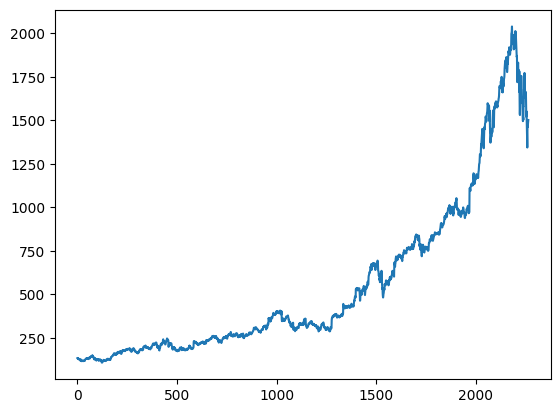

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#Ploting it
plt.plot(df_close)
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
df_close = scaler.fit_transform(df_close)

In [ ]:
train_size = int(len(df_close) * 0.80)
test_size = len(df_close) - train_size
train, test = df_close[0:train_size,:], df_close[train_size:len(df_close),:]
print(len(train), len(test))

1812 453


Normalize the values such that prices are reduced to normalized values and I can predict stock movement instead of actual prices

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1): #keep only similar value data if a data point is too far of the last one jump to the next value
	dataX, dataY = [], []       #put this in data x
	for i in range(len(dataset)-look_back-1): #let dataY have only output values
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    units = 100,
    input_shape=(None, 1),
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    units = 100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1))
model.add(Activation('relu'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
print ('compilation time : ', time.time() - start)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


compilation time :  0.009369373321533203


In [ ]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    epochs=80,
    validation_split=0.05)


Epoch 1/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.2275e-04 - mae: 0.0078 - val_loss: 1.0862e-04 - val_mae: 0.0094
Epoch 2/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4806e-04 - mae: 0.0091 - val_loss: 3.6524e-05 - val_mae: 0.0047
Epoch 3/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0061e-04 - mae: 0.0069 - val_loss: 7.0823e-05 - val_mae: 0.0073
Epoch 4/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2957e-04 - mae: 0.0083 - val_loss: 2.6642e-05 - val_mae: 0.0037
Epoch 5/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2194e-04 - mae: 0.0076 - val_loss: 3.4254e-05 - val_mae: 0.0045
Epoch 6/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3695e-04 - mae: 0.0084 - val_loss: 4.6762e-05 - val_mae: 0.0056
Epoch 7/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7933e-05 - mae: 0.0066 - val_loss: 6.1908e-05 - val_mae: 0.0067
Epoch 8/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2188e-04 - mae: 0.0080 - val_loss: 2.6603e-05 - val_mae: 0.0037
Epoch 9/

In [ ]:
model.fit(
    trainX,
    trainY,
    batch_size=128,
    epochs=40,
    validation_split=0.05)

Epoch 1/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1370e-04 - mae: 0.0076 - val_loss: 2.6689e-05 - val_mae: 0.0037
Epoch 2/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0157e-04 - mae: 0.0074 - val_loss: 3.0506e-05 - val_mae: 0.0041
Epoch 3/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0543e-04 - mae: 0.0071 - val_loss: 4.0550e-05 - val_mae: 0.0051
Epoch 4/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.4801e-05 - mae: 0.0067 - val_loss: 2.6638e-05 - val_mae: 0.0037
Epoch 5/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0180e-04 - mae: 0.0069 - val_loss: 7.4341e-05 - val_mae: 0.0076
Epoch 6/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0325e-04 - mae: 0.0074 - val_loss: 1.0665e-04 - val_mae: 0.0093
Epoch 7/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0971e-04 - mae: 0.0075 - val_loss: 9.6024e-05 - val_mae: 0.0088
Epoch 8/40
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1594e-04 - mae: 0.0081 - val_loss: 3.7307e-05 - val_mae: 0.0048
Epoch 9/

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


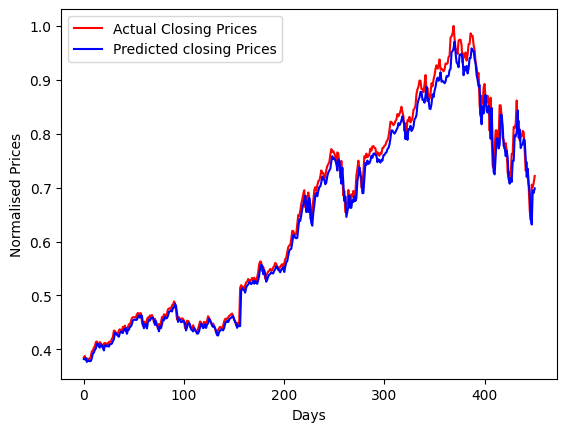

In [ ]:
import matplotlib.pyplot as plt
predicted_stateful = model.predict(testX)
plt.plot(testY, color = 'red',label = 'Actual Closing Prices')
plt.plot(predicted_stateful.flatten(), color = 'blue', label  = 'Predicted closing Prices')
plt.xlabel('Days')
plt.ylabel('Normalised Prices')
plt.legend(loc='best')
plt.show()

So LSTM works great to predict Closing Prices when we normalize the prices and predict the stock Price movement.

In [ ]:
mae = model.evaluate(trainX,
    trainY,
    batch_size=128,verbose=1)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3274e-05 - mae: 0.0028 
